# 03_Model Tuning with Categorical Features (2 & 3 Classes)

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.utils.class_weight import compute_sample_weight

from sklearn.metrics import plot_confusion_matrix, accuracy_score, precision_score, f1_score

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")

## Data

In [2]:
# OHE dataframe with the year features

protests_ohe_w_year = pd.read_csv('../data/protests_ohe_w_year.csv')

In [3]:
print(protests_ohe_w_year.shape)
protests_ohe_w_year.head(3)

(15198, 55)


,region_Africa,region_Asia,region_Central America,region_Europe,region_MENA,region_North America,region_Oceania,region_South America,year_1990,year_1991,year_1992,year_1993,year_1994,year_1995,year_1996,year_1997,year_1998,year_1999,year_2000,year_2001,year_2002,year_2003,year_2004,year_2005,year_2006,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,participants_category_100-999,participants_category_1000-1999,participants_category_2000-4999,participants_category_50-99,participants_category_5000-10000,participants_category_>10000,protesterviolence,demand_political_behavior_process,demand_labor_wage_dispute,demand_police_brutality,demand_social_restrictions,demand_land_farm_issue,demand_politician_removal,demand_price_inc_tax_policy,response_category_2,response_category_3
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [4]:
# OHE dataframe without the year features

protests_ohe_wo_year = pd.read_csv('../data/protests_ohe_wo_year.csv')

In [5]:
print(protests_ohe_wo_year.shape)
protests_ohe_wo_year.head(3)

(15198, 24)


,region_Africa,region_Asia,region_Central America,region_Europe,region_MENA,region_North America,region_Oceania,region_South America,participants_category_100-999,participants_category_1000-1999,participants_category_2000-4999,participants_category_50-99,participants_category_5000-10000,participants_category_>10000,protesterviolence,demand_political_behavior_process,demand_labor_wage_dispute,demand_police_brutality,demand_social_restrictions,demand_land_farm_issue,demand_politician_removal,demand_price_inc_tax_policy,response_category_2,response_category_3
0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


_______
## **#1. Modeling 2 Classes (with YEAR data)**

In [6]:
X2_year = protests_ohe_w_year.drop(columns=['response_category_2','response_category_3'])
y2_year = protests_ohe_w_year['response_category_2']

In [7]:
# Train/test split

X2_year_train, X2_year_test, y2_year_train, y2_year_test = train_test_split(X2_year, y2_year, test_size=0.2, random_state=42, stratify=y2_year)

In [8]:
print(y2_year_train.value_counts(normalize=True))
print(y2_year_test.value_counts(normalize=True))

0    0.772166
1    0.227834
Name: response_category_2, dtype: float64
0    0.772368
1    0.227632
Name: response_category_2, dtype: float64


### Logisitic Regression

In [10]:
logr2_year_params = {
    'penalty': ['none','l1','l2','elasticnet'], 
    'C': [1, 5, 10], 
    'solver': ['liblinear','lbfgs','newton-cg','sag','saga']
}

In [11]:
logr2_year_gs = GridSearchCV(
    estimator = LogisticRegression(class_weight = 'balanced',random_state = 42), 
    param_grid = logr2_year_params,
    cv = 3
)

In [12]:
logr2_year_gs.fit(X2_year_train, y2_year_train)

print('')
print('Best Params: ' + str(logr2_year_gs.best_params_))
print('Train Accuracy: ' + str(logr2_year_gs.score(X2_year_train, y2_year_train)))
print('Test Accuracy: ' + str(logr2_year_gs.score(X2_year_test, y2_year_test)))


Best Params: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Train Accuracy: 0.7587596644184899
Test Accuracy: 0.749671052631579


In [13]:
logr2_year_gs_pred = logr2_year_gs.predict(X2_year_test)

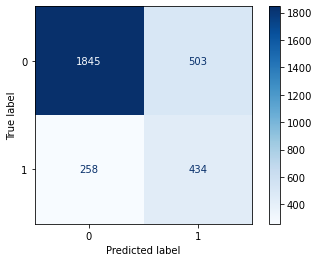

In [14]:
plot_confusion_matrix(logr2_year_gs, X2_year_test, y2_year_test, cmap='Blues', values_format='d', display_labels=['0',  '1']);

In [15]:
print('Test Precision: ' + str(precision_score(y2_year_test, logr2_year_gs_pred)))

Test Precision: 0.4631803628601921


For 2 classes and with year data, Logisitic Regression hardly did better than the baseline model. The baseline model achieved a 0.749342 test accuracy and a 0.462687 precision score. This tuned model achieved 0.74967 test accuracy and 0.46318 precision score.

### XGBoost

In [16]:
xgb2_year_params = {
    'booster': ['gbtree','dart'],
    'learning_rate': [0.3, 0.7],
    'max_depth': [4, 6],
    'lambda': [0, 1],
    'alpha': [0, 1],
    'n_estimators': [10, 50]
}

In [17]:
xgb2_year_rs = RandomizedSearchCV(
    estimator = XGBClassifier(scale_pos_weight = 3.38, random_state = 42),
    param_distributions = xgb2_year_params,
    cv = 3,
    random_state = 42
)

In [18]:
xgb2_year_rs.fit(X2_year_train, y2_year_train)

print('')
print('Best Params: ' + str(xgb2_year_rs.best_params_))
print('Train Accuracy: ' + str(xgb2_year_rs.score(X2_year_train, y2_year_train)))
print('Test Accuracy: ' + str(xgb2_year_rs.score(X2_year_test, y2_year_test)))


Best Params: {'n_estimators': 10, 'max_depth': 6, 'learning_rate': 0.3, 'lambda': 1, 'booster': 'dart', 'alpha': 1}
Train Accuracy: 0.7759499917749629
Test Accuracy: 0.7605263157894737


In [19]:
xgb2_year_rs_pred = xgb2_year_rs.predict(X2_year_test)

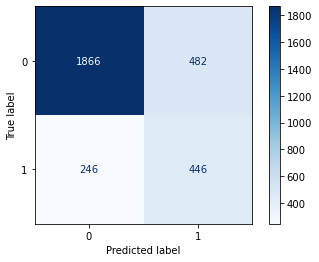

In [20]:
plot_confusion_matrix(xgb2_year_rs, X2_year_test, y2_year_test, cmap='Blues', values_format='d', display_labels=['0', '1']);

In [21]:
print('Test Precision: ' + str(precision_score(y2_year_test, xgb2_year_rs_pred)))

Test Precision: 0.48060344827586204


For 2 classes and with year data, XGBoost hardly did a little better than the baseline model. The baseline model achieved a 0.754934 test accuracy and a 0.472987 precision score. This tuned model achieved 0.76052 test accuracy and 0.48060 precision score.

### Support Vector Classifier

In [22]:
svc2_year_params = {
    'C': [1.0, 2.0],
    'kernel': ['poly','rbf','sigmoid'],
    'degree': [2, 3],
    'gamma': ['scale','auto'],
    'coef0': [0.0, 1.0]
}

In [23]:
svc2_year_rs = RandomizedSearchCV(
    estimator = SVC(class_weight = 'balanced', random_state = 42),
    param_distributions = svc2_year_params,
    cv = 3,
    random_state = 42
)

In [25]:
svc2_year_rs.fit(X2_year_train, y2_year_train)

print('')
print('Best Params: ' + str(svc2_year_rs.best_params_))
print('Train Accuracy: ' + str(svc2_year_rs.score(X2_year_train, y2_year_train)))
print('Test Accuracy: ' + str(svc2_year_rs.score(X2_year_test, y2_year_test)))


Best Params: {'kernel': 'poly', 'gamma': 'auto', 'degree': 2, 'coef0': 0.0, 'C': 2.0}
Train Accuracy: 0.7768547458463563
Test Accuracy: 0.7713815789473685


In [26]:
svc2_year_rs_pred = svc2_year_rs.predict(X2_year_test)

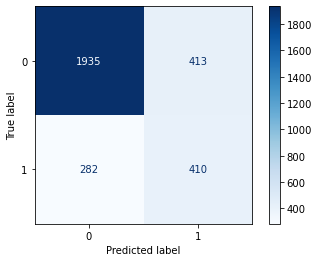

In [27]:
plot_confusion_matrix(svc2_year_rs, X2_year_test, y2_year_test, cmap='Blues', values_format='d', display_labels=['0', '1']);

In [28]:
print('Test Precision: ' + str(precision_score(y2_year_test, svc2_year_rs_pred)))

Test Precision: 0.49817739975698666


For 2 classes and with year data, Support Vector Classifier had more noticable improvement in comparison to the baseline model. The baseline model achieved a 0.751974 test accuracy and a 0.468876 precision score. This tuned model achieved 0.77138 test accuracy and 0.49817 precision score.

**The best performer for modeling 2 classes with year data: Support Vector Classifier - Test Accuracy: .771 / Precision: .498**

_______
## **#2. Modeling 3 Classes (with YEAR data)**

In [30]:
X3_year = protests_ohe_w_year.drop(columns=['response_category_2','response_category_3'])
y3_year = protests_ohe_w_year['response_category_3']

In [31]:
# Train/test split

X3_year_train, X3_year_test, y3_year_train, y3_year_test = train_test_split(X3_year, y3_year, test_size=0.2, random_state=42, stratify=y3_year)

In [32]:
print(y3_year_train.value_counts(normalize=True))
print(y3_year_test.value_counts(normalize=True))

0    0.525333
1    0.246833
2    0.227834
Name: response_category_3, dtype: float64
0    0.525329
1    0.247039
2    0.227632
Name: response_category_3, dtype: float64


### XGBoost

In [33]:
xgb3_year_params = {
    'booster': ['gbtree','dart'],
    'learning_rate': [0.1, 0.3, 0.5],
    'max_depth': [4, 6, 10],
    'lambda': [0, 1],
    'alpha': [0, 1],
    'n_estimators': [10, 50, 100]
}

In [34]:
xgb3_year_rs = RandomizedSearchCV(
    estimator = XGBClassifier(random_state = 42),
    param_distributions = xgb3_year_params,
    cv = 3,
    random_state = 42
)

In [35]:
xgb3_year_rs.fit(X3_year_train, y3_year_train, sample_weight = compute_sample_weight('balanced', y3_year_train))

print('')
print('Best Params: ' + str(xgb3_year_rs.best_params_))
print('Train Accuracy: ' + str(xgb3_year_rs.score(X3_year_train, y3_year_train)))
print('Test Accuracy: ' + str(xgb3_year_rs.score(X3_year_test, y3_year_test)))


Best Params: {'n_estimators': 10, 'max_depth': 6, 'learning_rate': 0.3, 'lambda': 1, 'booster': 'dart', 'alpha': 1}
Train Accuracy: 0.6461589077150847
Test Accuracy: 0.6302631578947369


In [36]:
xgb3_year_rs_pred = xgb3_year_rs.predict(X3_year_test)

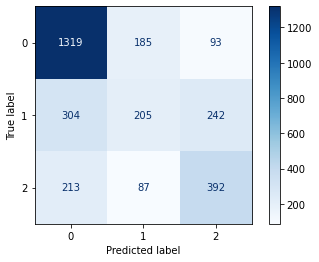

In [37]:
plot_confusion_matrix(xgb3_year_rs, X3_year_test, y3_year_test, cmap='Blues', values_format='d', display_labels=['0', '1', '2']);

In [38]:
print('Test Precision: ' + str(precision_score(y3_year_test, xgb3_year_rs_pred, average = 'weighted', labels = [2])))

Test Precision: 0.5392022008253095


For 3 classes and with year data, XGBoost performed worse than the baseline model. The baseline model achieved a 0.640132 test accuracy and a 0.611746 precision score. This tuned model achieved 0.63026 test accuracy and 0.53920 precision score.

### Support Vector Classifier

In [39]:
svc3_year_params = {
    'C': [1.0, 2.0],
    'kernel': ['poly','rbf','sigmoid'],
    'degree': [2,3],
    'gamma': ['scale','auto'],
    'coef0': [0.0, 1.0]
}

In [40]:
svc3_year_rs = RandomizedSearchCV(
    estimator = SVC(class_weight = 'balanced', random_state = 42),
    param_distributions = svc2_year_params,
    cv = 3,
    random_state = 42
)

In [41]:
svc3_year_rs.fit(X3_year_train, y3_year_train)

print('')
print('Best Params: ' + str(svc3_year_rs.best_params_))
print('Train Accuracy: ' + str(svc3_year_rs.score(X3_year_train, y3_year_train)))
print('Test Accuracy: ' + str(svc3_year_rs.score(X3_year_test, y3_year_test)))


Best Params: {'kernel': 'poly', 'gamma': 'auto', 'degree': 2, 'coef0': 0.0, 'C': 2.0}
Train Accuracy: 0.6329988484948182
Test Accuracy: 0.6332236842105263


In [42]:
svc3_year_rs_pred = svc3_year_rs.predict(X3_year_test)

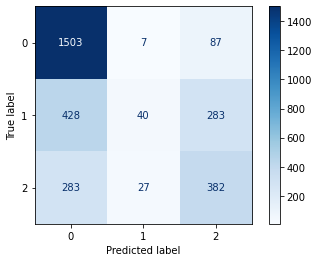

In [43]:
plot_confusion_matrix(svc3_year_rs, X3_year_test, y3_year_test, cmap='Blues', values_format='d', display_labels=['0', '1', '2']);

In [44]:
print('Test Precision: ' + str(precision_score(y3_year_test, svc3_year_rs_pred, average = 'weighted', labels = [2])))

Test Precision: 0.5079787234042553


For 3 classes and with year data, Support Vector Classifier herdly performed a little better than the baseline model in terms of accuracy, but performed much worse in terms of precision. The baseline model achieved a 0.623026 test accuracy and a 0.604485 precision score. This tuned model achieved 0.63322 test accuracy and 0.50797 precision score.

**The best performer for modeling 3 classes with year data: XGBoost - Test Accuracy: .630 / Precision: .539**

_______
## **#3. Modeling 2 Classes (NO YEAR data)**

In [46]:
X2 = protests_ohe_wo_year.drop(columns=['response_category_2','response_category_3'])
y2 = protests_ohe_wo_year['response_category_2']

In [47]:
# Train/test split

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42, stratify=y2)

In [48]:
print(y2_train.value_counts(normalize=True))
print(y2_test.value_counts(normalize=True))

0    0.772166
1    0.227834
Name: response_category_2, dtype: float64
0    0.772368
1    0.227632
Name: response_category_2, dtype: float64


### Logistic Regression

In [49]:
logr2_params = {
    'penalty': ['none','l1','l2','elasticnet'], 
    'C': [1, 5, 10], 
    'solver': ['liblinear','lbfgs','newton-cg','sag','saga']
}

In [50]:
logr2_gs = GridSearchCV(
    estimator = LogisticRegression(class_weight = 'balanced',random_state = 42), 
    param_grid = logr2_params,
    cv = 3
)

In [51]:
logr2_gs.fit(X2_train, y2_train)

print('')
print('Best Params: ' + str(logr2_gs.best_params_))
print('Train Accuracy: ' + str(logr2_gs.score(X2_train, y2_train)))
print('Test Accuracy: ' + str(logr2_gs.score(X2_test, y2_test)))


Best Params: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Train Accuracy: 0.7571146570159566
Test Accuracy: 0.75


In [52]:
logr2_gs_pred = logr2_gs.predict(X2_test)

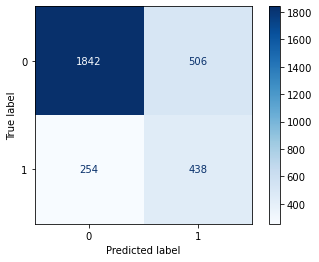

In [53]:
plot_confusion_matrix(logr2_gs, X2_test, y2_test, cmap='Blues', values_format='d', display_labels=['0',  '1']);

In [54]:
print('Test Precision: ' + str(precision_score(y2_test, logr2_gs_pred)))

Test Precision: 0.4639830508474576


For 2 classes and no year data, Logisitic Regression did worse than the baseline model. The baseline model achieved a 0.765132 test accuracy and a 0.487059 precision score. This tuned model achieved 0.75 test accuracy and 0.46398 precision score.

### XGBoost

In [55]:
xgb2_params = {
    'booster': ['gbtree','dart'],
    'learning_rate': [0.3, 0.7],
    'max_depth': [4, 6],
    'lambda': [0, 1],
    'alpha': [0, 1],
    'n_estimators': [10, 50]
}

In [56]:
xgb2_rs = RandomizedSearchCV(
    estimator = XGBClassifier(scale_pos_weight = 3.38, random_state = 42),
    param_distributions = xgb2_params,
    cv = 3,
    random_state = 42
)

In [57]:
xgb2_rs.fit(X2_train, y2_train)

print('')
print('Best Params: ' + str(xgb2_rs.best_params_))
print('Train Accuracy: ' + str(xgb2_rs.score(X2_train, y2_train)))
print('Test Accuracy: ' + str(xgb2_rs.score(X2_test, y2_test)))


Best Params: {'n_estimators': 10, 'max_depth': 6, 'learning_rate': 0.3, 'lambda': 1, 'booster': 'dart', 'alpha': 1}
Train Accuracy: 0.7646816910676099
Test Accuracy: 0.7513157894736842


In [58]:
xgb2_rs_pred = xgb2_rs.predict(X2_test)

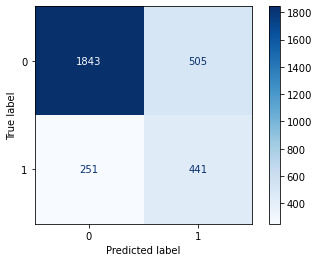

In [59]:
plot_confusion_matrix(xgb2_rs, X2_test, y2_test, cmap='Blues', values_format='d', display_labels=['0', '1']);

In [60]:
print('Test Precision: ' + str(precision_score(y2_test, xgb2_rs_pred)))

Test Precision: 0.46617336152219874


For 2 classes and no year data, XGBoost did worse than the baseline model. The baseline model achieved a 0.753947 test accuracy and a 0.470149 precision score. This tuned model achieved 0.75131 test accuracy and 0.46617 precision score.

### Support Vector Classifier

In [61]:
svc2_params = {
    'C': [1.0, 2.0],
    'kernel': ['poly','rbf','sigmoid'],
    'degree': [2, 3],
    'gamma': ['scale','auto'],
    'coef0': [0.0, 1.0]
}

In [62]:
svc2_rs = RandomizedSearchCV(
    estimator = SVC(class_weight = 'balanced', random_state = 42),
    param_distributions = svc2_params,
    cv = 3,
    random_state = 42
)

In [63]:
svc2_rs.fit(X2_train, y2_train)

print('')
print('Best Params: ' + str(svc2_rs.best_params_))
print('Train Accuracy: ' + str(svc2_rs.score(X2_train, y2_train)))
print('Test Accuracy: ' + str(svc2_rs.score(X2_test, y2_test)))


Best Params: {'kernel': 'poly', 'gamma': 'auto', 'degree': 2, 'coef0': 0.0, 'C': 2.0}
Train Accuracy: 0.7768547458463563
Test Accuracy: 0.7713815789473685


In [64]:
svc2_rs_pred = svc2_rs.predict(X2_test)

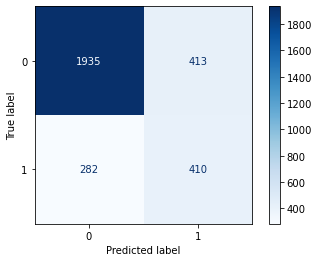

In [65]:
plot_confusion_matrix(svc2_rs, X2_test, y2_test, cmap='Blues', values_format='d', display_labels=['0', '1']);

In [66]:
print('Test Precision: ' + str(precision_score(y2_test, svc2_rs_pred)))

Test Precision: 0.49817739975698666


For 2 classes and no year data, Support Vector Classifier just about the same as the baseline model in terms of accuracy, but did better with precision. The baseline model achieved a 0.772368 test accuracy and a 0.000000 precision score. This tuned model achieved 0.77138 test accuracy and 0.49817 precision score.

**The best performer for modeling 2 classes with no year data: Support Vector Classifier - Test Accuracy: .771 / Precision: .498**

_______
## **#4. Modeling 3 Classes (NO YEAR data)**

In [67]:
X3 = protests_ohe_wo_year.drop(columns=['response_category_2','response_category_3'])
y3 = protests_ohe_wo_year['response_category_3']

In [68]:
# Train/test split

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42, stratify=y3)

In [69]:
print(y3_train.value_counts(normalize=True))
print(y3_test.value_counts(normalize=True))

0    0.525333
1    0.246833
2    0.227834
Name: response_category_3, dtype: float64
0    0.525329
1    0.247039
2    0.227632
Name: response_category_3, dtype: float64


### XGBoost

In [71]:
xgb3_params = {
    'booster': ['gbtree','dart'],
    'learning_rate': [0.1, 0.3, 0.5],
    'max_depth': [4, 6, 10],
    'lambda': [0, 1],
    'alpha': [0, 1],
    'n_estimators': [10, 50, 100]
}

In [72]:
xgb3_rs = RandomizedSearchCV(
    estimator = XGBClassifier(random_state = 42),
    param_distributions = xgb3_params,
    cv = 3,
    random_state = 42
)

In [73]:
xgb3_rs.fit(X3_train, y3_train, sample_weight = compute_sample_weight('balanced', y3_train))

print('')
print('Best Params: ' + str(xgb3_rs.best_params_))
print('Train Accuracy: ' + str(xgb3_rs.score(X3_train, y3_train)))
print('Test Accuracy: ' + str(xgb3_rs.score(X3_test, y3_test)))


Best Params: {'n_estimators': 10, 'max_depth': 6, 'learning_rate': 0.1, 'lambda': 1, 'booster': 'gbtree', 'alpha': 1}
Train Accuracy: 0.6156440203980917
Test Accuracy: 0.6098684210526316


In [74]:
xgb3_rs_pred = xgb3_rs.predict(X3_test)

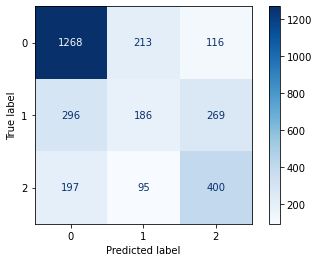

In [75]:
plot_confusion_matrix(xgb3_rs, X3_test, y3_test, cmap='Blues', values_format='d', display_labels=['0', '1', '2']);

In [76]:
print('Test Precision: ' + str(precision_score(y3_test, xgb3_rs_pred, average = 'weighted', labels = [2])))

Test Precision: 0.5095541401273885


For 3 classes and no year data, XGBoost did worse than the baseline model. The baseline model achieved a 0.634211 test accuracy and a 0.603785 precision score. This tuned model achieved 0.60986 test accuracy and 0.50955 precision score.

### Support Vector Classifier

In [77]:
svc3_params = {
    'C': [1.0, 2.0],
    'kernel': ['poly','rbf','sigmoid'],
    'degree': [2,3],
    'gamma': ['scale','auto'],
    'coef0': [0.0, 1.0]
}

In [78]:
svc3_rs = RandomizedSearchCV(
    estimator = SVC(class_weight = 'balanced', random_state = 42),
    param_distributions = svc2_params,
    cv = 3,
    random_state = 42
)

In [79]:
svc3_rs.fit(X3_train, y3_train)

print('')
print('Best Params: ' + str(svc3_rs.best_params_))
print('Train Accuracy: ' + str(svc3_rs.score(X3_train, y3_train)))
print('Test Accuracy: ' + str(svc3_rs.score(X3_test, y3_test)))


Best Params: {'kernel': 'poly', 'gamma': 'auto', 'degree': 2, 'coef0': 0.0, 'C': 2.0}
Train Accuracy: 0.6255963151834183
Test Accuracy: 0.6273026315789474


In [80]:
svc3_rs_pred = svc3_rs.predict(X3_test)

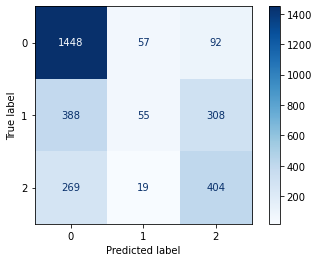

In [81]:
plot_confusion_matrix(svc3_rs, X3_test, y3_test, cmap='Blues', values_format='d', display_labels=['0', '1', '2']);

In [82]:
print('Test Precision: ' + str(precision_score(y3_test, svc3_rs_pred, average = 'weighted', labels = [2])))

Test Precision: 0.5024875621890548


For 3 classes and no year data, Support Vector Classifier did much better than the baseline model. The baseline model achieved a 0.227632 test accuracy and a 0.051816 precision score. This tuned model achieved 0.62730 test accuracy and  0.50248 precision score.

**The best performer for modeling 3 classes with no year data: Support Vector Classifier - Test Accuracy: .627 / Precision: .502**

____
## Model Tuning Comparison & Evaluation

Even after some considerable tuning, none of the models did much better than the baseline models, and some actually performed worse. Of the models, however, the best-performing was the Support Vector Classifier when using 2 classes. It achieved the highest test accuracy score, which was the primary goal. The use of year data did not make a difference.

____
## Model Tuning Final Thoughts

As suspected in the EDA process, this dataset containing all categorical features was not ideal for modeling and there was not a model identified that could be pushed to production.